In [1]:
!gdown 1ZdhRqYv-JizWV6DxO6C4R_k1kxPhmlF2

Downloading...
From: https://drive.google.com/uc?id=1ZdhRqYv-JizWV6DxO6C4R_k1kxPhmlF2
To: /content/multiclass.csv
100% 14.6k/14.6k [00:00<00:00, 31.9MB/s]


Libraries:

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Load your dataset
df = pd.read_csv('multiclass.csv')

# Display the first few rows and get some info
print("First 5 rows of the dataset:")
print(df.head())
print("\nDataset information:")
df.info()

First 5 rows of the dataset:
   Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen  class
0       3  12669  9656     7561     214              2674        1338      2
1       3   7057  9810     9568    1762              3293        1776      2
2       3   6353  8808     7684    2405              3516        7844      2
3       3  13265  1196     4221    6404               507        1788      1
4       3  22615  5410     7198    3915              1777        5185      1

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Region            440 non-null    int64
 1   Fresh             440 non-null    int64
 2   Milk              440 non-null    int64
 3   Grocery           440 non-null    int64
 4   Frozen            440 non-null    int64
 5   Detergents_Paper  440 non-null    int64
 6   Delicassen        

Preprocessing the data:
1. Null values handling. (here, i am taking median).
2. Removing duplicates.
3. Removing outliers.
4. Converting categorical data to the numeric data.
5. Feature scaling: (if there are 10 features, then we will convert them into 0-1 range - for making all the features equally important).

In [3]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('multiclass.csv')
print("Original shape of the dataset:", df.shape)

# --- 1.1 Handle Null Values ---
# Check for any missing values in each column
print("\nMissing values before handling:\n", df.isnull().sum())
# For simplicity, we'll fill any missing numerical values with the median of that column
# The median is often a good choice because it's not affected by outliers
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(), inplace=True)
print("\nMissing values after handling:\n", df.isnull().sum())


# --- 1.2 Remove Duplicates ---
# Check how many duplicate rows exist
print(f"\nNumber of duplicate rows before removal: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Number of duplicate rows after removal: {df.duplicated().sum()}")


# --- 1.3 Remove Outliers (using IQR method) ---
# Outliers can skew the model. We'll remove extreme values.
print("\nShape before removing outliers:", df.shape)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
# We create a condition to keep rows that are within 1.5 * IQR of Q1 and Q3
is_not_outlier = ~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)
df = df[is_not_outlier]
print("Shape after removing outliers:", df.shape)


# --- 1.4 Convert Categorical to Numerical Data ---
# KNN works with numbers, not text labels. We'll use one-hot encoding on the 'Region' column.
# This creates new columns (e.g., 'Region_1', 'Region_2') with 1s and 0s.
df = pd.get_dummies(df, columns=['Region'], drop_first=True)
print("\nFirst 5 rows after converting categorical columns:")
print(df.head())


# --- 1.5 Feature Scaling ---
# This is VITAL for KNN! It ensures all features have the same importance.
# We scale all columns except our target variable, 'class'.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_to_scale = df.columns.drop('class')
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
print("\nFirst 5 rows after feature scaling:")
print(df.head())

Original shape of the dataset: (440, 8)

Missing values before handling:
 Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
class               0
dtype: int64

Missing values after handling:
 Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
class               0
dtype: int64

Number of duplicate rows before removal: 0
Number of duplicate rows after removal: 0

Shape before removing outliers: (440, 8)
Shape after removing outliers: (332, 8)

First 5 rows after converting categorical columns:
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen  class  \
0  12669  9656     7561     214              2674        1338      2   
1   7057  9810     9568    1762              3293        1776      2   
3  13265  1196     4221    6404               507        1788      1   
5   941

/tmp/ipython-input-2555763413.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


Splitting the data:

Into training and the testing set. This helps you understand how well your model will perform on new, unseen data.


In [4]:
from sklearn.model_selection import train_test_split

# 'X' contains all our features, and 'y' contains the target variable ('class')
X = df.drop('class', axis=1)
y = df['class']

# We'll use 80% of the data for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (265, 8)
Testing set shape: (67, 8)


KNN Logic:

1. Pass the Data.
2. Calculate Distances.
3. Sort and Find Neighbors.
4. Vote for the Class.

In [5]:
from collections import Counter

def predict_with_knn(X_train, y_train, query_point, k=3):
    """
    Predicts the class for a single query point using the KNN algorithm.
    """
    # 3.2: From the query point, find distances to each and every point.
    distances = []
    for index, train_point in X_train.iterrows():
        # Calculate Euclidean distance
        distance = np.linalg.norm(train_point - query_point)
        # Store the distance and the class label of that training point
        distances.append((distance, y_train.loc[index]))

    # 3.3: Sort the distances based on ascending order.
    sorted_distances = sorted(distances, key=lambda x: x[0])

    # 3.4: Give a k value and check the top k classes.
    k_nearest_neighbors = sorted_distances[:k]

    # Get the labels of the k-nearest neighbors
    k_nearest_labels = [neighbor[1] for neighbor in k_nearest_neighbors]

    # Find the most common label (majority vote)
    most_common = Counter(k_nearest_labels).most_common(1)
    prediction = most_common[0][0]

    return prediction

# --- Let's try it! ---
# We'll take the first data point from our test set as our 'query_point'
query = X_test.iloc[0]
k_value = 5 # Let's use 5 neighbors

# 3.1: Pass the query and the dataset to our function
prediction = predict_with_knn(X_train, y_train, query, k=k_value)

print(f"\nQuery Point (first row of test set):\n{query}")
print(f"\nModel Prediction for the query point with k={k_value}: {prediction}")
print(f"Actual Value for the query point: {y_test.iloc[0]}")


Query Point (first row of test set):
Fresh               2.476413
Milk                0.202731
Grocery             0.288270
Frozen              2.502147
Detergents_Paper   -0.681750
Delicassen          0.080666
Region_2           -0.332217
Region_3            0.623796
Name: 33, dtype: float64

Model Prediction for the query point with k=5: 2
Actual Value for the query point: 2


Visualization:


/tmp/ipython-input-2996889703.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


The plot has been saved as 'knn_visualization.png'


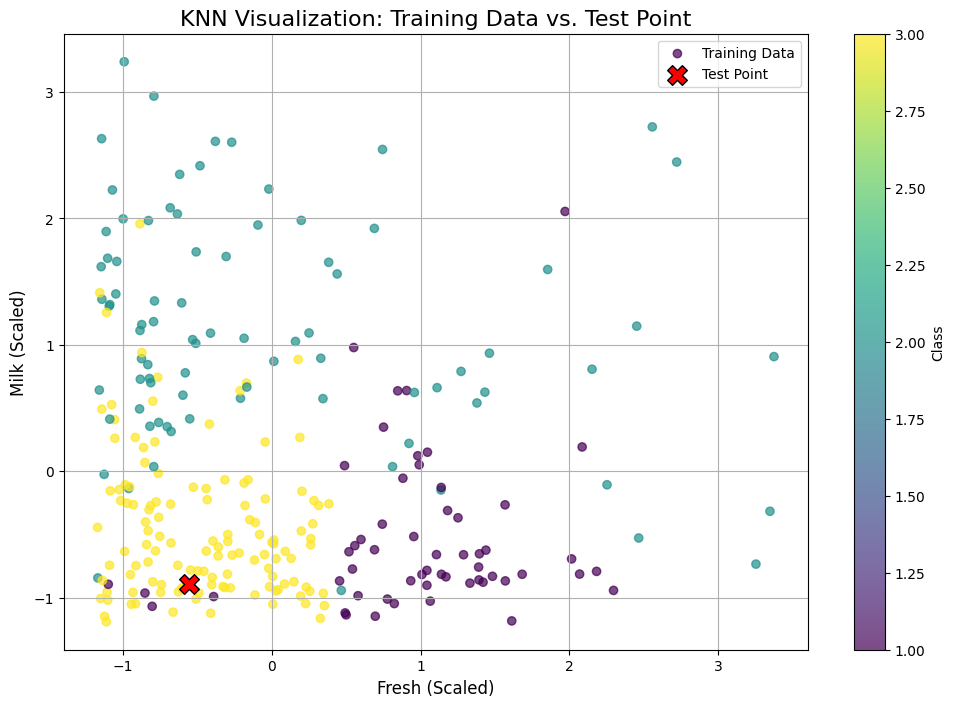

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- Step 1: Repeat the Preprocessing to Get the Data Ready ---
# This ensures we're plotting the exact data the model sees.
df = pd.read_csv('multiclass.csv')

# Handle Nulls, Duplicates, and Outliers
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(), inplace=True)
df.drop_duplicates(inplace=True)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
is_not_outlier = ~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)
df = df[is_not_outlier]

# Separate features (X) and target (y) BEFORE scaling
X = df.drop('class', axis=1)
y = df['class']

# Convert Categorical columns AFTER splitting features
X = pd.get_dummies(X, columns=['Region'], drop_first=True)

# Save column names before scaling (since scaler outputs a numpy array)
feature_names = X.columns

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled data back to a DataFrame to easily select columns by name
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names, index=X.index)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Get the specific test point.
query_point = X_test.iloc[5]


# --- Step 2: Create the Scatter Plot ---
plt.figure(figsize=(12, 8))

# Plot all the training data points
# The 'c=y_train' argument colors each point according to its class label
scatter = plt.scatter(
    X_train['Fresh'],
    X_train['Milk'],
    c=y_train,
    cmap='viridis',  # A nice color scheme
    alpha=0.7,       # Make points slightly transparent
    label='Training Data'
)

# Plot the single test point (query_point)
# We make it a larger, red 'X' to ensure it's clearly visible
plt.scatter(
    query_point['Fresh'],
    query_point['Milk'],
    c='red',         # A distinct color
    marker='X',      # A different shape
    s=200,           # A larger size
    edgecolor='black',
    label='Test Point'
)

# --- Step 3: Add Labels and Final Touches ---
plt.title('KNN Visualization: Training Data vs. Test Point', fontsize=16)
plt.xlabel('Fresh (Scaled)', fontsize=12)
plt.ylabel('Milk (Scaled)', fontsize=12)
plt.grid(True)
plt.legend()

# Add a colorbar to show which color corresponds to which class
plt.colorbar(scatter, label='Class')

# Save the plot to a file
plt.savefig('knn_visualization.png')

print("The plot has been saved as 'knn_visualization.png'")

Calculation Metrics:



In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# --- Step 1: Load and Preprocess the Data ---
try:
    df = pd.read_csv('multiclass.csv')

    # Handle Nulls, Duplicates, and Outliers
    for col in df.select_dtypes(include=np.number).columns:
        df[col].fillna(df[col].median(), inplace=True)
    df.drop_duplicates(inplace=True)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    # Note: A potential typo `IQR = Q3 - Q3` was corrected to `IQR = Q3 - Q1`
    is_not_outlier = ~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)
    df = df[is_not_outlier]

    # Separate features (X) and target (y)
    X = df.drop('class', axis=1)
    y = df['class']

    # Convert Categorical to Numerical
    X = pd.get_dummies(X, columns=['Region'], drop_first=True)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature Scaling (Fit on training data only!)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Step 2: Find the Optimal K Value ---
    error_rate = []
    for i in range(1, 40):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test)
        error_rate.append(np.mean(pred_i != y_test))

    optimal_k = error_rate.index(min(error_rate)) + 1
    print(f"Optimal K value found: {optimal_k}\n")

    # --- Step 3: Train Final Model and Make Predictions ---
    final_knn = KNeighborsClassifier(n_neighbors=optimal_k)
    final_knn.fit(X_train, y_train)
    y_pred = final_knn.predict(X_test)

    # --- Step 4: Display Overall Evaluation Metrics ---
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Model Accuracy: {accuracy:.2%}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # --- Step 5: Show Actual vs. Predicted Labels for Each Test Point ---
    # Create a new DataFrame for easy comparison
    results_df = pd.DataFrame({'Actual Label': y_test, 'Predicted Label': y_pred})

    # Resetting index to show a clean 0, 1, 2... sequence
    results_df.reset_index(drop=True, inplace=True)

    print("\n-------------------------------------------------")
    print("Comparison of Actual vs. Predicted Labels:")
    print("-------------------------------------------------")
    print(results_df.to_string()) # .to_string() ensures all rows are printed

except FileNotFoundError:
    print("Error: 'multiclass.csv' not found. Please ensure the file is in the correct directory.")
except Exception as e:
    print(f"An error occurred: {e}")


/tmp/ipython-input-654542054.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


Optimal K value found: 4

Overall Model Accuracy: 89.55%

Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.91      0.80        11
           2       0.95      0.83      0.88        23
           3       0.94      0.94      0.94        33

    accuracy                           0.90        67
   macro avg       0.87      0.89      0.87        67
weighted avg       0.91      0.90      0.90        67


-------------------------------------------------
Comparison of Actual vs. Predicted Labels:
-------------------------------------------------
    Actual Label  Predicted Label
0              2                2
1              3                3
2              2                2
3              2                1
4              2                2
5              3                3
6              2                2
7              1                1
8              3                3
9              3                3
10             2    